# College Finder: Technical Documentation

This project aims to develop College Finder, a college-student matching system by evaluating compatibility based on various student preferences and institutional data. The system utilizes various machine learning algorithms, including neural network autoencoders, PCA for dimensionality reduction and k-Nearest Neighbors (kNN) for compatibility scoring, to recommend the most suitable colleges for students. Through preprocessing, feature transformation, and similarity calculations, the model ranks colleges based on how closely they match the student's profile. The following sections describe the approach, coding steps, and models used to achieve this goal.

In [1]:
import pandas as pd
import numpy as np
import scipy
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

2024-12-11 16:23:12.197090: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-11 16:23:12.199830: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-11 16:23:12.240849: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-11 16:23:12.240877: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-11 16:23:12.241765: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

## Demo: Student input for Bentley University

In [2]:
# Initialize student input dataframe for Bentley University
student_input = pd.DataFrame({
    "StateCode": ["MA"],               # Bentley is in Massachusetts
    "Control": ["2"],                  # Bentley is a private university
    "Size": [3],                       # Bentley's size falls in the "1,000 - 4,999" range
    "Selectivity": [4],                # Bentley has a relatively selective admission rate (relative)
    "StudentFacultyRatioBin": [2],     # Bentley has a student to faculty ratio of 12:1 (bin 1)
    "TestOptional": [1],               # Bentley is test-optional
    "SATVRMID": [650],                 # Average SAT Reading score for admitted students
    "SATMTMID": [677],                 # Average SAT Math score for admitted students
    "ACTENMID": [29],                  # Average ACT English score for admitted students
    "ACTMTMID": [31],                  # Average ACT Math score for admitted students
    "Tuition": [5],                    # Bentley is among the more expensive schools
    "LivingCost": [3],                 # Waltham living costs are relatively high
    "CrimeRate": [4],                  # Moderate-high (relative) crime rate in Waltham, MA
    "Diversity": [4],                  # Moderate-high (relative) diversity index
    "Population": [2]                  # Waltham is sparsely populated (relative)
})

# Display the created dataframe
print(student_input)

  StateCode Control  Size  Selectivity  StudentFacultyRatioBin  TestOptional  \
0        MA       2     3            4                       2             1   

   SATVRMID  SATMTMID  ACTENMID  ACTMTMID  Tuition  LivingCost  CrimeRate  \
0       650       677        29        31        5           3          4   

   Diversity  Population  
0          4           2  


# Autoencoder

## Load college dataset

In [3]:
college_data = pd.read_csv("miced_matching_data.csv")
college_data.columns = ["InstitutionName"] + list(student_input.columns)

num_cols = ['Size', 'Selectivity', 'StudentFacultyRatioBin',
            'SATVRMID', 'SATMTMID', 'ACTENMID', 'ACTMTMID',
            'Tuition', 'LivingCost', 'CrimeRate', 'Diversity', 'Population']

cat_cols = ['StateCode']

## Preprocessing pipeline

The data preprocessing involves handling numerical and categorical variables separately. Numerical features are imputed with the mean and standardized, while categorical features are imputed with the most frequent value and one-hot encoded. These transformations are combined using ColumnTransformer() function, and the processed data is converted to a dense format if required.

In [4]:
# Define preprocessing for numerical columns
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Impute missing numerical values
    ('scaler', StandardScaler())  # Standardize numerical values
])

# Define preprocessing for categorical columns
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing categorical values
    ('encoder', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode categorical values
])

# Combine both transformations using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', cat_transformer, cat_cols)
    ]
)

college_preprocessed = preprocessor.fit_transform(college_data)

# Convert sparse matrix to dense if necessary
if isinstance(college_preprocessed, scipy.sparse.spmatrix):
    college_preprocessed = college_preprocessed.toarray()

## Autoencoder development

### Building

In [5]:
input_dim = college_preprocessed.shape[1]

autoencoder = Sequential([
    Dense(10, activation='relu', input_dim=input_dim),  # Encoding layer
    Dense(input_dim, activation='sigmoid')  # Decoding layer
])

autoencoder.compile(optimizer='adam', loss='mean_squared_error')

### Training

In [6]:
autoencoder.fit(college_preprocessed, college_preprocessed, epochs=50, batch_size=32, verbose=1)

Epoch 1/50
121/121 [==============================] - 1s 2ms/step - loss: 0.3551
Epoch 2/50
121/121 [==============================] - 0s 2ms/step - loss: 0.2205
Epoch 3/50
121/121 [==============================] - 0s 2ms/step - loss: 0.1646
Epoch 4/50
121/121 [==============================] - 0s 1ms/step - loss: 0.1484
Epoch 5/50
121/121 [==============================] - 0s 2ms/step - loss: 0.1410
Epoch 6/50
121/121 [==============================] - 0s 2ms/step - loss: 0.1362
Epoch 7/50
121/121 [==============================] - 0s 2ms/step - loss: 0.1327
Epoch 8/50
121/121 [==============================] - 0s 2ms/step - loss: 0.1300
Epoch 9/50
121/121 [==============================] - 0s 2ms/step - loss: 0.1277
Epoch 10/50
121/121 [==============================] - 0s 2ms/step - loss: 0.1259
Epoch 11/50
121/121 [==============================] - 0s 2ms/step - loss: 0.1243
Epoch 12/50
121/121 [==============================] - 0s 2ms/step - loss: 0.1231
Epoch 13/50
121/121 [====

### Encodings generation

In [7]:
# Step 5: Generate Encodings
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.layers[0].output)
college_encodings = encoder.predict(college_preprocessed)

# Preprocess and encode the student input
student_preprocessed = preprocessor.transform(student_input)
student_encoding = encoder.predict(student_preprocessed)

1/1 [==============================] - 0s 51ms/step


### Cosine similarity score computation

In [8]:
# Step 6: Calculate cosine similarity Scores
similarities_autoenc = cosine_similarity(student_encoding, college_encodings).flatten()

In [9]:
similarities_autoenc

array([0.19005641, 0.7593203 , 0.4618209 , ..., 0.68313074, 0.31871918,
       0.47923917], dtype=float32)

### Top 10 recommendations

In [10]:
# Get top 10 recommendations
top_10_indices_autoenc = similarities_autoenc.argsort()[-10:][::-1]  # Indices of top 10 similar schools
top_10_schools_autoenc = college_data.iloc[top_10_indices_autoenc]

# Calculate the scaled similarity scores (out of 100)
scaled_scores_autoenc = (similarities_autoenc[top_10_indices_autoenc] * 100).round(2)  # Scale to 100 and round to 2 decimal places

# Print the top 10 recommendations with their scaled similarity scores
print("Top 10 Recommended Institutions:")
top_10_schools_autoenc["SimilarityScore"] = scaled_scores_autoenc
print(top_10_schools_autoenc[["InstitutionName", "SimilarityScore"]])

Top 10 Recommended Institutions:
                          InstitutionName  SimilarityScore
1132                   Bentley University       100.000000
724      Illinois Institute of Technology        98.809998
1602      Stevens Institute of Technology        98.559998
1785     Rensselaer Polytechnic Institute        97.879997
1104  University of Maryland-College Park        97.839996
1128                       Babson College        97.809998
2663                   Trinity University        97.809998
545                   University of Miami        97.800003
1586   New Jersey Institute of Technology        97.760002
1599                Seton Hall University        97.570000
/tmp/ipykernel_459/4225120453.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

# Principal Component Analysis (PCA)

In [11]:
# Step 1: Preprocessing
# Use college_preprocessed data

# Step 2: Apply PCA
pca = PCA()

# Fit and transform the data
pca.fit(college_preprocessed)

PCA()

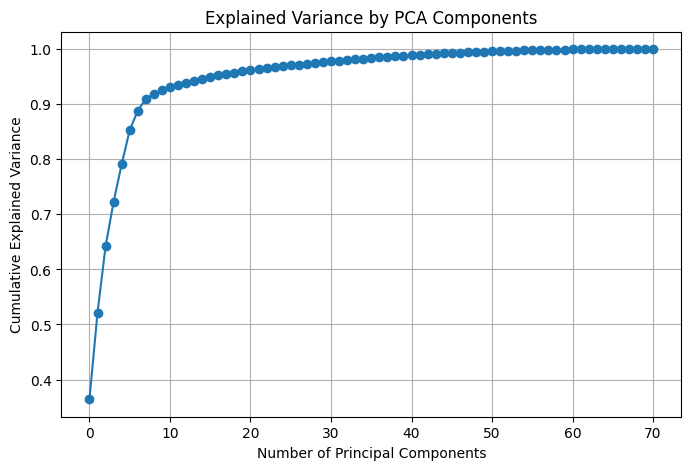

In [12]:
# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
#print("\nExplained Variance Ratio:")
#print(explained_variance_ratio)

# Cumulative explained variance
cumulative_variance = np.cumsum(explained_variance_ratio)
#print("\nCumulative Explained Variance:")
#print(cumulative_variance)

# Plot cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(cumulative_variance, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.grid()
plt.show()

In [13]:
# Step 3: Select number of components (e.g., to retain 95% variance)
n_components = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Number of components to retain 95% variance: {n_components}")

# Apply PCA with the selected number of components
pca_optimal = PCA(n_components=n_components)

# Fit and transform the data
pca_optimal.fit(college_preprocessed)

Number of components to retain 95% variance: 17


PCA(n_components=17)

In [14]:
# Step 4: Generate PCA
# Preprocess and transform the student data using the optimal pipeline
student_pca = pca_optimal.transform(student_preprocessed.toarray())

# Transform the college data using the same pipeline
college_pca = pca_optimal.transform(college_preprocessed)

# Step 5: Calculate cosine similarity Scores
similarities_pca = cosine_similarity(student_pca, college_pca).flatten()

In [15]:
# Step 6: Get top 10 recommendations
top10_indices_pca = similarities_pca.argsort()[-10:][::-1]  # Indices of top 10 similar schools
top10_schools_pca = college_data.iloc[top10_indices_pca,]

# Calculate the scaled similarity scores (out of 100)
scaled_scores_pca = (similarities_pca[top10_indices_pca] * 100).round(2)  # Scale to 100 and round to 2 decimal places

# Print the top 10 recommendations with their scaled similarity scores
print("Top 10 Recommended Institutions:")
top10_schools_pca["SimilarityScore"] = scaled_scores_pca
print(top10_schools_pca[["InstitutionName", "SimilarityScore"]])

Top 10 Recommended Institutions:
                          InstitutionName  SimilarityScore
1132                   Bentley University           100.00
1602      Stevens Institute of Technology            98.24
724      Illinois Institute of Technology            97.97
691                 University of Chicago            97.84
1785     Rensselaer Polytechnic Institute            97.81
2619                      Rice University            97.63
1606            The College of New Jersey            96.91
2524                Vanderbilt University            96.84
1062                        Colby College            96.79
1104  University of Maryland-College Park            96.54
/tmp/ipykernel_459/1893880118.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

# k-Nearest Neighbors

In [16]:
# Step 1: Define preprocessing
# Use the same preproccessor_num defined earlier

# Step 2: Define the KNN model
knn = NearestNeighbors(n_neighbors=len(college_preprocessed), metric='euclidean')  # KNN with 10 neighbors, if we want top 20 list we have to change n_neighbors

# Step 3: Fit the model to the data
knn.fit(college_preprocessed, college_data.index)

NearestNeighbors(metric='euclidean', n_neighbors=3857)

In [17]:
# Step 4: Calculate kNN distances and indices for all colleges
distances_knn, indices_knn = knn.kneighbors(student_preprocessed)

# Step 5: Flatten distances and indices for all colleges
all_distances = distances_knn.flatten()  # All distances to colleges
all_indices = indices_knn.flatten()  # All college indices

# Step 6: Sort the distances and retrieve the top 10 closest colleges
sorted_indices_top10 = all_distances.argsort()[:10]  # Indices of the top 10 closest colleges
top10_indices_knn = all_indices[sorted_indices_top10]  # Map to the correct college indices
top10_schools_knn = college_data.iloc[top10_indices_knn].copy()  # Get top 10 colleges
top10_schools_knn["Distance"] = all_distances[sorted_indices_top10]  # Add distances

# Print the top 10 recommended schools sorted by smallest distance
print(top10_schools_knn[["InstitutionName", "Distance"]])

                          InstitutionName  Distance
1132                   Bentley University  0.000000
724      Illinois Institute of Technology  1.760466
1586   New Jersey Institute of Technology  2.204198
1170  University of Massachusetts-Amherst  2.266362
2414                    Furman University  2.368917
1599                Seton Hall University  2.451702
1717                   Hofstra University  2.468667
1606            The College of New Jersey  2.502334
2037                   Denison University  2.522046
1851       United States Military Academy  2.573722


# Aggregate all recommendations

Creating Autoencoder result DataFrame with rankings

In [18]:
# Sort the cosine similarity scores and assign ranks
sorted_indices_autoenc = similarities_autoenc.argsort()[::-1]  # Sort in descending order (highest similarity first)
sorted_similarities_autoenc= similarities_autoenc[sorted_indices_autoenc]  # Reorder similarities
sorted_college_indices_autoenc = college_data.index[sorted_indices_autoenc]  # Reorder college indices

# Step 7: Create the DataFrame with InstitutionName, AutoencCosine, and AutoencRank
college_autoenc_scores = pd.DataFrame({
    "InstitutionName": college_data.iloc[sorted_college_indices_autoenc]["InstitutionName"].values,
    "AutoencCosine": sorted_similarities_autoenc,
    "AutoencRank": range(1, len(sorted_college_indices_autoenc) + 1)  # Rank starting from 1
})

# Preview the top 15 results
print(college_autoenc_scores.head(15))

                        InstitutionName  AutoencCosine  AutoencRank
0                    Bentley University       1.000000            1
1      Illinois Institute of Technology       0.988099            2
2       Stevens Institute of Technology       0.985581            3
3      Rensselaer Polytechnic Institute       0.978827            4
4   University of Maryland-College Park       0.978369            5
5                        Babson College       0.978122            6
6                    Trinity University       0.978057            7
7                   University of Miami       0.977988            8
8    New Jersey Institute of Technology       0.977590            9
9                 Seton Hall University       0.975691           10
10  University of Massachusetts-Amherst       0.975662           11
11      Florida Institute of Technology       0.975483           12
12                University of Chicago       0.973186           13
13                   Hofstra University       0.

Creating PCA result DataFrame with rankings

In [19]:
# Sort the cosine similarity scores and assign ranks
sorted_indices_pca = similarities_pca.argsort()[::-1]  # Sort in descending order (highest similarity first)
sorted_similarities_pca = similarities_pca[sorted_indices_pca]  # Reorder similarities
sorted_college_indices_pca = college_data.index[sorted_indices_pca]  # Reorder college indices

#Create the DataFrame with InstitutionName, PCACosine, and PCARank
college_pca_scores = pd.DataFrame({
    "InstitutionName": college_data.iloc[sorted_college_indices_pca]["InstitutionName"].values,
    "PCACosine": sorted_similarities_pca,
    "PCARank": range(1, len(sorted_college_indices_pca) + 1)  # Rank starting from 1
})

# Preview the top 15 results
print(college_pca_scores.head(15))

                        InstitutionName  PCACosine  PCARank
0                    Bentley University   1.000000        1
1       Stevens Institute of Technology   0.982416        2
2      Illinois Institute of Technology   0.979745        3
3                 University of Chicago   0.978398        4
4      Rensselaer Polytechnic Institute   0.978118        5
5                       Rice University   0.976319        6
6             The College of New Jersey   0.969130        7
7                 Vanderbilt University   0.968396        8
8                         Colby College   0.967869        9
9   University of Maryland-College Park   0.965395       10
10   New Jersey Institute of Technology   0.963588       11
11             Colorado School of Mines   0.962988       12
12           University of Pennsylvania   0.961156       13
13                 Princeton University   0.960920       14
14                    Dartmouth College   0.960314       15


Creating KNN result DataFrame with rankings

In [20]:
# Retrieve the indices in sorted order
sorted_indices_knn = all_distances.argsort()
sorted_college_indices_knn = all_indices[sorted_indices_knn]  # Map to college indices

# Create a DataFrame for all colleges with distance and rank
college_distances = pd.DataFrame({
    "InstitutionName": college_data.iloc[sorted_college_indices_knn]["InstitutionName"].values,
    "KnnDistance": all_distances[sorted_indices_knn],
    "KnnRank": range(1, len(sorted_college_indices_knn) + 1)  # Rank starting from 1
})

# Preview the top 15 results
print(college_distances.head(15))

                        InstitutionName  KnnDistance  KnnRank
0                    Bentley University     0.000000        1
1      Illinois Institute of Technology     1.760466        2
2    New Jersey Institute of Technology     2.204198        3
3   University of Massachusetts-Amherst     2.266362        4
4                     Furman University     2.368917        5
5                 Seton Hall University     2.451702        6
6                    Hofstra University     2.468667        7
7             The College of New Jersey     2.502334        8
8                    Denison University     2.522046        9
9        United States Military Academy     2.573722       10
10                      St Olaf College     2.591712       11
11             Colorado School of Mines     2.651726       12
12                   Trinity University     2.657473       13
13            University of Connecticut     2.697571       14
14      United States Air Force Academy     2.712265       15


Merging the result dataframes!

In [21]:
# Merge the three DataFrames on InstitutionName
merged_scores = pd.merge(college_autoenc_scores, college_pca_scores, on="InstitutionName", suffixes=("_Autoenc", "_PCA"))
merged_scores = pd.merge(merged_scores, college_distances, on="InstitutionName")

# Calculate the average rank
merged_scores["AvgRank"] = merged_scores[["AutoencRank", "PCARank", "KnnRank"]].mean(axis=1)

# Sort by the average rank in ascending order (best rank first)
merged_scores = merged_scores.sort_values(by="AvgRank").reset_index(drop=True)

# Preview the top results
print(merged_scores.head(15))

# Optional: Save the merged DataFrame for future use
merged_scores.to_csv("merged_college_scores.csv", index=False)


                        InstitutionName  AutoencCosine  AutoencRank  \
0                    Bentley University       1.000000            1   
1      Illinois Institute of Technology       0.988099            2   
2    New Jersey Institute of Technology       0.977590            9   
3             The College of New Jersey       0.965917           22   
4                 Seton Hall University       0.975691           10   
5       Stevens Institute of Technology       0.985581            3   
6                     Furman University       0.967425           19   
7   University of Massachusetts-Amherst       0.975662           11   
8                        Babson College       0.978122            6   
9   University of Maryland-College Park       0.978369            5   
10             Colorado School of Mines       0.960968           28   
11                   Trinity University       0.978057            7   
12     Rensselaer Polytechnic Institute       0.978827            4   
13    

Aggregating the results to get the final similarity / compatibility score

In [22]:
# Normalize KNN Distance Score
min_knn_dist = merged_scores["KnnDistance"].min()
max_knn_dist = merged_scores["KnnDistance"].max()
merged_scores["KNN_Normalized"] = 1 - (merged_scores["KnnDistance"] - min_knn_dist) / (max_knn_dist - min_knn_dist)

# Calculate Aggregated Score
merged_scores["AggregatedScore"] = round((merged_scores["PCACosine"] + merged_scores["AutoencCosine"]
                                    + merged_scores["KNN_Normalized"]) / 3 * 100, 3)

# Sort by Aggregated Score
merged_scores = merged_scores.sort_values(by="AggregatedScore", ascending=False)

# Display the top 10 universities
print(merged_scores[["InstitutionName", "AggregatedScore"]].head(15))

                        InstitutionName  AggregatedScore
0                    Bentley University          100.000
1      Illinois Institute of Technology           96.002
2    New Jersey Institute of Technology           94.376
3             The College of New Jersey           93.676
7   University of Massachusetts-Amherst           93.565
4                 Seton Hall University           93.483
5       Stevens Institute of Technology           93.468
6                     Furman University           93.278
10             Colorado School of Mines           93.058
11                   Trinity University           92.983
8                        Babson College           92.961
12     Rensselaer Polytechnic Institute           92.878
9   University of Maryland-College Park           92.842
15                   Hofstra University           92.448
14      United States Air Force Academy           92.432


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=28f6e439-b516-405e-ad62-5aa314d601ab' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>